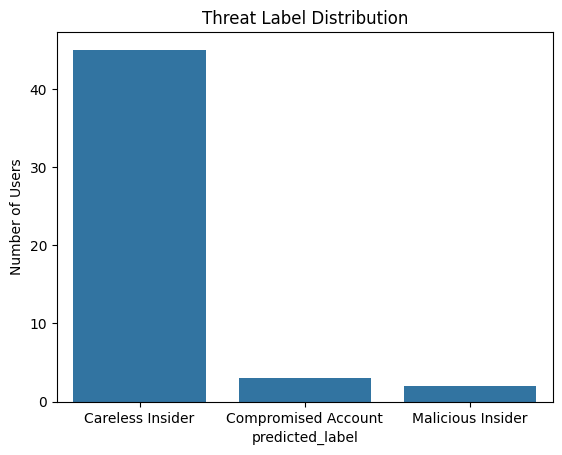

✅ Dataset saved to: C:\Users\sagni\Downloads\Insider Threat Detection\threat_users.csv


In [1]:
# 📚 Step 1: Import all necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
# 🧪 Step 2: Generate Synthetic Enterprise Logs
def generate_synthetic_logs(num_users=50, days=10):
    logs = []
    base_time = datetime.now()

    for user_id in range(1, num_users + 1):
        for day in range(days):
            date = base_time - timedelta(days=day)
            logins = random.randint(1, 3)
            for _ in range(logins):
                login_time = date + timedelta(hours=random.randint(6, 22))
                file_access = random.randint(5, 20)
                email_count = random.randint(10, 50)
                privileged_access = random.choices([0, 1], weights=[0.9, 0.1])[0]
                logs.append({
                    'user_id': f'user_{user_id}',
                    'timestamp': login_time,
                    'file_access_count': file_access,
                    'email_sent': email_count,
                    'privileged_access': privileged_access
                })
    
    return pd.DataFrame(logs)

logs_df = generate_synthetic_logs()
logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'])
logs_df.head()
# 🧼 Step 3: Feature Engineering
features_df = logs_df.copy()
features_df['hour'] = features_df['timestamp'].dt.hour
features_df = features_df.groupby('user_id').agg({
    'file_access_count': 'mean',
    'email_sent': 'mean',
    'privileged_access': 'sum',
    'hour': 'mean'
}).reset_index()

# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df.drop('user_id', axis=1))
features_df_scaled = pd.DataFrame(X_scaled, columns=['file_access', 'email_sent', 'privileged_access', 'avg_hour'])
features_df_scaled['user_id'] = features_df['user_id']
# 🚨 Step 4: Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
features_df_scaled['anomaly_score'] = iso_forest.fit_predict(features_df_scaled.drop('user_id', axis=1))
# 🔀 Step 5: User Behavior Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
features_df_scaled['cluster'] = kmeans.fit_predict(features_df_scaled.drop(['user_id', 'anomaly_score'], axis=1))
# 🏷️ Step 6: Threat Label Assignment Function
def assign_threat_label(row):
    if row['privileged_access'] > 2:
        return 'Malicious Insider'
    elif row['anomaly_score'] == -1:
        return 'Compromised Account'
    else:
        return 'Careless Insider'

features_df_scaled['predicted_label'] = features_df_scaled.apply(assign_threat_label, axis=1)
# 🧠 Step 7: Optional Classifier Training (for experimentation)
X = features_df_scaled.drop(['user_id', 'predicted_label'], axis=1)
y = features_df_scaled['predicted_label']
clf = RandomForestClassifier()
clf.fit(X, y)
features_df_scaled['predicted_label'] = clf.predict(X)
# 📊 Step 8: Visualize Threat Distribution
label_counts = features_df_scaled['predicted_label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Threat Label Distribution")
plt.ylabel("Number of Users")
plt.show()
# 💾 Step 9: Save the Final Results to the Given Path
output_folder = r"C:\Users\sagni\Downloads\Insider Threat Detection"
os.makedirs(output_folder, exist_ok=True)

output_path = os.path.join(output_folder, "threat_users.csv")
features_df_scaled[['user_id', 'predicted_label']].to_csv(output_path, index=False)

print(f"✅ Dataset saved to: {output_path}")
